<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_FINAL_MSFT_LSTM_SENTIMENT_60M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
pip install statsmodels

In [ ]:
pip install yahoofinancials

  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp37-none-any.whl size=15192 sha256=90d5ee35c9354cb0b36ce4305c7aec14b4e896080681c50b8477e1112597bbeb
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Successfully built yahoofinancials


In [ ]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from keras import regularizers


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns 

import sklearn
from sklearn.linear_model import ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
# Get stock data
start='2020-01-01'
end='2021-01-03'
df = yf.download(tickers = "MSFT",start=start,end=end,interval = "60m")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.head()


[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Adj Close,Volume,Next_close
0,2020-01-02 09:30:00-05:00,158.779999,159.554993,158.330002,159.100006,159.100006,5598544,159.485001
1,2020-01-02 10:30:00-05:00,159.095001,159.630005,158.990005,159.485001,159.485001,2349407,159.529999
2,2020-01-02 11:30:00-05:00,159.479996,159.619995,159.110001,159.529999,159.529999,1784440,159.615005
3,2020-01-02 12:30:00-05:00,159.520004,159.800003,159.445007,159.615005,159.615005,1571495,159.934998
4,2020-01-02 13:30:00-05:00,159.615005,159.949997,159.529999,159.934998,159.934998,1508504,160.070007


Text(0, 0.5, 'Cost (USD)')

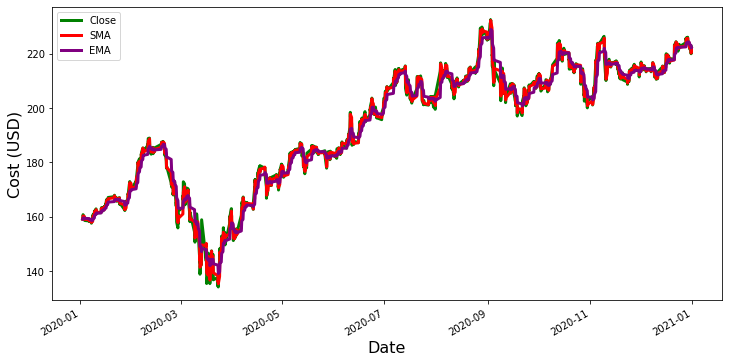

In [ ]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

# Plot price changes for the year
# Colors for the line plot
colors = ['green', 'red', 'purple']
df_plt = df[['Close', 'SMA', 'EMA', 'Datetime']]

# line plot
df_plt.plot(color=colors, x = 'Datetime', linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# title and labels
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cost (USD)', fontsize=16)

In [ ]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Datetime')


In [ ]:
# Create hour_id for merging with Sentiment Data
df = df.reset_index()
df['date'] = df['Datetime'].dt.date  # for daily sentiment
df['datehour'] = df['Datetime'].dt.hour     #For hourly sentiment
df['hour_id'] = df[df.columns[-2:]].apply(
    lambda x: '.'.join(x.dropna().astype(str)),
    axis=1
)

In [ ]:
# Import Sentiment Data
sent = pd.read_csv('MSFT_sentiment_hr.csv')
sent

,Unnamed: 0,hour_id,compound,Count,average
0,0,2019-12-31.23,-0.4019,2,-0.200950
1,1,2020-01-01.16,-0.1661,1,-0.166100
2,2,2020-01-01.21,-0.0697,2,-0.034850
3,3,2020-01-01.22,0.2586,1,0.258600
4,4,2020-01-01.23,0.3818,1,0.381800
...,...,...,...,...,...
7559,7559,2020-12-31.4,1.3475,3,0.449167
7560,7560,2020-12-31.5,0.8979,4,0.224475
7561,7561,2020-12-31.7,-0.2924,1,-0.292400
7562,7562,2020-12-31.8,0.0000,2,0.000000


In [ ]:
# Merge Dataframes
df = pd.merge(df, sent, on = 'hour_id', how = 'left')
#df = df.fillna(0)
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1.764000e+03,1763.000000,1764.000000,1764.000000,1.764000e+03,1764.000000,1549.000000,1549.000000,1549.000000,1549.000000
mean,192.922239,193.825921,191.999376,192.941001,192.941001,4.566292e+06,192.960196,192.905329,192.619718,2.331774e+08,11.994898,3787.248547,0.312523,15.728857,0.041792
std,22.957954,22.785290,23.090392,22.939181,22.939181,3.129898e+06,22.931514,22.918551,22.752246,1.350495e+08,2.000702,2172.138666,1.982829,29.219588,0.225441
min,134.160004,137.250000,132.520004,134.139999,134.139999,0.000000e+00,134.139999,135.313334,139.093149,-7.974553e+07,9.000000,8.000000,-17.594100,1.000000,-0.845500
25%,173.881248,174.474998,172.899994,173.799923,173.799923,2.562148e+06,173.869949,173.581750,173.271001,1.191854e+08,10.000000,1910.000000,-0.460600,3.000000,-0.055300
50%,200.864998,201.840004,199.910004,200.931046,200.931046,3.564974e+06,200.932098,201.257484,201.059177,2.833942e+08,12.000000,3773.000000,0.212600,7.000000,0.023575
75%,212.389999,213.184994,211.602505,212.397499,212.397499,5.511006e+06,212.404999,212.350416,212.242562,3.474824e+08,14.000000,5671.000000,0.952700,15.000000,0.140094
max,232.354996,232.860001,231.350006,232.350006,232.350006,2.795370e+07,232.350006,232.180003,228.858003,4.074811e+08,15.000000,7563.000000,22.077400,337.000000,0.955900


In [ ]:
# Check for correlation between sentiment and price change
df['per_change'] = ((df['Next_close'] - df['Close'])/df['Next_close'])*100
df.corr()

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv,datehour,Unnamed: 0,compound,Count,average,per_change
Open,1.000000,0.999042,0.999121,0.998368,0.998368,-0.371304,0.996288,0.999067,0.992487,0.955913,-0.002690,0.863786,-0.007141,0.035633,-0.010940,-0.027233
High,0.999042,1.000000,0.998422,0.999152,0.999152,-0.350797,0.996740,0.999001,0.992934,0.956461,-0.009911,0.867903,-0.006428,0.034206,-0.010437,-0.032727
Low,0.999121,0.998422,1.000000,0.999080,0.999080,-0.390154,0.996957,0.998783,0.991397,0.955869,0.004206,0.860626,-0.007267,0.037562,-0.009705,-0.028055
Close,0.998368,0.999152,0.999080,1.000000,1.000000,-0.369038,0.997498,0.998725,0.991552,0.956408,-0.003988,0.863812,-0.006422,0.036341,-0.009200,-0.034402
Adj Close,0.998368,0.999152,0.999080,1.000000,1.000000,-0.369038,0.997498,0.998725,0.991552,0.956408,-0.003988,0.863812,-0.006422,0.036341,-0.009200,-0.034402
Volume,-0.371304,-0.350797,-0.390154,-0.369038,-0.369038,1.000000,-0.370304,-0.368575,-0.356954,-0.351767,-0.326642,-0.274150,0.038550,-0.013254,-0.000738,-0.021247
Next_close,0.996288,0.996740,0.996957,0.997498,0.997498,-0.370304,1.000000,0.996556,0.989549,0.955429,-0.001806,0.863407,-0.004474,0.036599,-0.007842,0.035425
SMA,0.999067,0.999001,0.998783,0.998725,0.998725,-0.368575,0.996556,1.000000,0.994022,0.956101,-0.001629,0.865119,-0.008225,0.036087,-0.012521,-0.028640
EMA,0.992487,0.992934,0.991397,0.991552,0.991552,-0.356954,0.989549,0.994022,1.000000,0.952828,-0.000320,0.874314,-0.028000,0.031556,-0.022292,-0.026138
obv,0.955913,0.956461,0.955869,0.956408,0.956408,-0.351767,0.955429,0.956101,0.952828,1.000000,-0.001669,0.909789,-0.038897,-0.027594,-0.032959,-0.012099


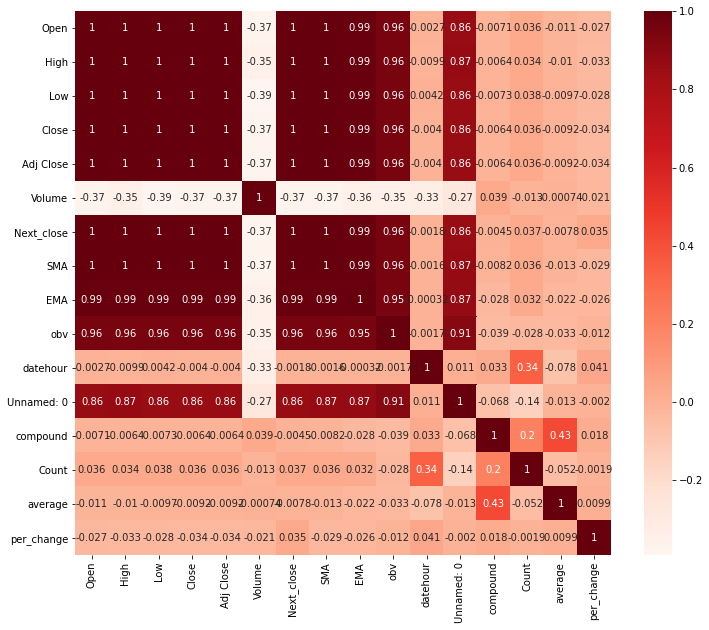

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df = df[['Next_close','Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

In [ ]:
# Scale data with MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()

# Data Loader Parameters
BATCH_SIZE = 17       # Factors of 1411 (train size):  1, 17, 83, 1411
BUFFER_SIZE = 130
TRAIN_SPLIT = round(len(df)*0.8)  # 80-20 train-test split 
print(TRAIN_SPLIT) # Batches should be factor of train size

# LSTM Parameters
EVALUATION_INTERVAL = 20   
EPOCHS = 500 # Early stopping implemented, so this can be artbitrarily high and still work
PATIENCE = 10  # number of epochs to wait before early stop if no progress on the validation set. # Tested this out with other values 3 and 5

1411


**Scaling the Data**

The values in our datset are of different scales which can increase the difficulty of the problem being modeled. The volume of traders per day is much higher than the value for the previous day's high, open, etc. This high value mayresult in a model that learns large weight values. A model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error. For this reason we scale our data before proceeding

MinMaxScaler() subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. This scaling method preserves the shape of the original distribution. It doesn't meaningfully change the information embedded in the original data. Note that MinMaxScaler doesn't reduce the importance of outliers. The default range for the feature returned by MinMaxScaler is 0 to 1


In [ ]:
# Scaled data with MinMaxScaler
 # from pandas df to array of values
data = df.values
# define min max scaler
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(data)

In [ ]:
# Split into endogenous and exogenous 
X = dataset[:,1:]
y = dataset[:, 0]


# LSTM Model

In [ ]:
# This was taken from the book Deep Learning with Python by François Chollet 

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [ ]:
past_history = 130    # How far back the model looks
future_target = 1 # this analysis is concerned with 1 step (hour/day) into the future
STEP = 1    

x_train_model, y_train_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_model, y_val_model = multivariate_data(X,y, 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

In [ ]:
print(x_train_model.shape)
print ('Window of past history : {}'.format(x_train_model[0].shape))
print(x_train_model.shape[-2:])

(1281, 130, 9)
Window of past history : (130, 9)
(130, 9)


In [ ]:
train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() 
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  ##Shuffle with buffer

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?

model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #adam said to be best in CV


In [ ]:
# Grid Search
# This build classifier and KerasClassifer step is taken from https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/. It is a wrapped which allows the use of Sklearn CV with Keras

def build_classifier(optimizer, dropout_rate):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                 kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                 input_shape=x_train_model.shape[-2:]))    # LSTM layer with input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # activation = sigmoid? Because I have normalised it to be between -1 and 1? Or no activation?
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #
  return model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [1, 17, 83, 1411],
              'optimizer' : ['adam','RMSprop'],
              'dropout_rate' : [0.0, 0.1, 0.2],  #What is 'forgotten' - important to avoid overfitting
}

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 2)

In [ ]:
#GridSearchCV
grid_search = grid_search.fit(x_train_model, y_train_model)

640/640 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 12s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


640/640 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


641/641 [==============================] - 13s 17ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 41ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 41ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 46ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 43ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 41ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 4s 43ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


38/38 [==============================] - 3s 42ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 44ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 47ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 44ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 44ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 43ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 49ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 46ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 47ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 44ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 43ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 3s 46ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 2s 50ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1/1 [==============================] - 2s 2s/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1281/1281 [==============================] - 24s 18ms/step - loss: nan - mean_absolute_error: nan - mape: nan


In [ ]:
print("Best accuracy: {}\nBest combination: {}".format(-grid_search.best_score_, 
                             grid_search.best_params_))

Best accuracy: 0.31234109690845396
Best combination: {'batch_size': 1, 'dropout_rate': 0.0, 'optimizer': 'adam'}


In [ ]:
BREAK TO UPDATE

SyntaxError: ignored

In [ ]:
BATCH_SIZE = 1
DROPOUT_RATE = 0
OPTIMIZER = 'adam'

train_data_model = tf.data.Dataset.from_tensor_slices((x_train_model, y_train_model))
train_data_model = train_data_model.cache().batch(BATCH_SIZE).repeat()
val_data_model = tf.data.Dataset.from_tensor_slices((x_val_model, y_val_model))
val_data_model = val_data_model.cache().batch(BATCH_SIZE).repeat()  

In [ ]:
# Model updated with parameters as determined using Grid Search
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 4, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
model.add(tf.keras.layers.Dropout(DROPOUT_RATE))   # Add dropout rate
model.add(tf.keras.layers.Dense(1)) 
model.compile(optimizer='RMSprop', loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) #


In [ ]:
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

# Train with early stopping so as to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True) 
history = model.fit(train_data_model,
                                            epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_model,
                                            callbacks=[early_stopping],
                                            validation_steps=17)   

Evaluation Threshold: 20
Epochs: 500
Epoch 1/500
20/20 [==============================] - 3s 55ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: nan - val_mape: nan
Epoch 2/500
20/20 [==============================] - 1s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: nan - val_mape: nan
Epoch 3/500
20/20 [==============================] - 1s 32ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: nan - val_mape: nan
Epoch 4/500
20/20 [==============================] - 1s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: nan - val_mape: nan
Epoch 5/500
20/20 [==============================] - 1s 31ms/step - loss: nan - mean_absolute_error: nan - mape: nan - val_loss: nan - val_mean_absolute_error: nan - val_mape: nan
Epoch 6/500
20/20 [==============================] - 1s 31ms/st

In [ ]:
history

In [ ]:
# Plot training 

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

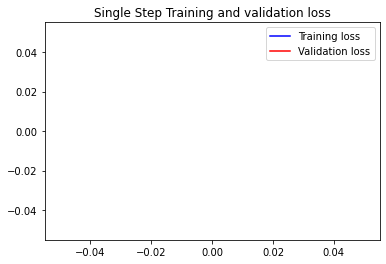

In [ ]:
plot_train_history(history,
                   'Single Step Training and validation loss')

In [ ]:
# Plot 3 examples of predictions for different timeframes
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

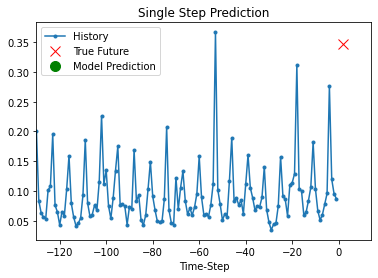

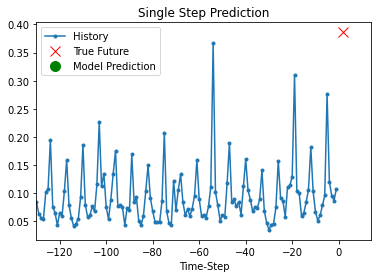

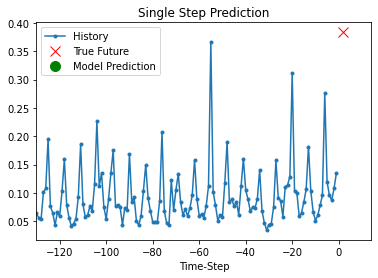

In [ ]:
for x, y in val_data_model.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 2,
                   'Single Step Prediction')
    plot.show()

## Cross Validation

In [ ]:
# Blocking Cross Validation
n_splits = 10
X = dataset[:,1:]
y= dataset[:,0]

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# Keras Wrapper
from keras.wrappers.scikit_learn import KerasClassifier
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(4,    # Capacity best out of:2, 8, 32
                                           kernel_regularizer = regularizers.l2(0.001), # Regularization - fight overfitting - is this correct?
                                           input_shape=x_train_model.shape[-2:]))    # LSTM layer with 4 outputs and input shape of x_train_model.shape[-2:]
  model.add(tf.keras.layers.Dropout(0.2))   # Add dropout rate
  model.add(tf.keras.layers.Dense(1)) # 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error',  metrics=['mean_absolute_error', 'mape']) 
  return model


In [ ]:
model = KerasClassifier(build_fn=create_model)
btscv = BlockingTimeSeriesSplit(n_splits=10)    # Or should I use TimeSeriesSplit?
mse_block= -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_squared_error')
mae_block = -cross_val_score(model, x_train_model, y_train_model, cv=btscv, scoring='neg_mean_absolute_error')

2/2 [==============================] - 2s 29ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 28ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 29ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 32ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 31ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 33ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 31ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 1s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 29ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 29ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 32ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 31ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 31ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 2s 30ms/step - loss: nan - mean_absolute_error: nan - mape: nan


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('The mean squared errors for each of the 10 splits are:', mse_block)
print('The mean mse for the folds is: ', (sum(mse_block)/10))

print('The mean absolute errors for each of the 10 splits are:', mae_block)
print('The mean mae for the folds is: ', (sum(mae_block)/10))

The mean squared errors for each of the 10 splits are: [0.02152461 0.00675071 0.12004598 0.0251755  0.00951963 0.03125818
 0.00221412 0.01275304 0.00145195 0.03025118]
The mean mse for the folds is:  0.02609448881293234
The mean absolute errors for each of the 10 splits are: [0.13323199 0.07402293 0.3411101  0.15461303 0.09308435 0.16828145
 0.03357818 0.10364778 0.03308532 0.16530125]
The mean mae for the folds is:  0.12999563845272072


In [ ]:
df_results = pd.DataFrame(mse_block)
df_results['RMSE'] = np.sqrt(df_results[0])
df_results = df_results.rename(columns={0:'MSFT_MSE', 'RMSE':'MSFT_RMSE'})
df_results

,MSFT_MSE,MSFT_RMSE
0,0.021525,0.146713
1,0.006751,0.082163
2,0.120046,0.346477
3,0.025175,0.158668
4,0.009520,0.097569
5,0.031258,0.176800
6,0.002214,0.047054
7,0.012753,0.112929
8,0.001452,0.038104
9,0.030251,0.173929


In [ ]:
df_results.to_csv('MSFT_SENTIMENT_LSTM_HR.csv')


In [ ]:
df_results.describe()

,MSFT_MSE,MSFT_RMSE
count,10.000000,10.000000
mean,0.026094,0.138041
std,0.034796,0.088439
min,0.001452,0.038104
25%,0.007443,0.086014
50%,0.017139,0.129821
75%,0.028982,0.170113
max,0.120046,0.346477
